In [3]:
import numpy as np
import pandas as pd
from numpy.random import randn
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import imp
import align_utils
import pf_utils
imp.reload(align_utils)
imp.reload(pf_utils)

from align_utils import *
from pf_utils import *

import random
import particle_filter
imp.reload(particle_filter)
from particle_filter import *
import pandas as pd
from tqdm import tqdm

import cv2
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
img = plt.imread("BF1.png")

In [ ]:
H = img.shape[0]
W = img.shape[1]

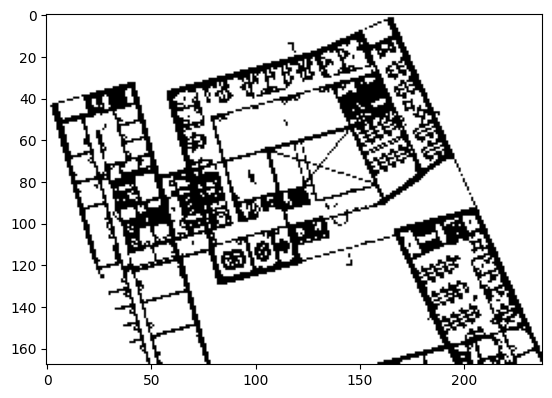

In [ ]:
img_rescaled = rescale(img[:, :, 0], 0.1, anti_aliasing=True)
threshold = 0.8
img_thresh = np.where(img_rescaled > threshold, 1, 0)
plt.imshow(img_thresh, cmap='gray')

In [ ]:
img_walk = plt.imread("BF1_walkable.png")

In [ ]:
imgwlk_rescaled = rescale(img_walk[:, :, 0], 0.1, anti_aliasing=False)

In [ ]:
erosion_size = 1
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                    (2 * erosion_size + 1, 2 * erosion_size + 1), 
                                    (erosion_size, erosion_size))
erosion_dst = cv2.erode(imgwlk_rescaled, element)

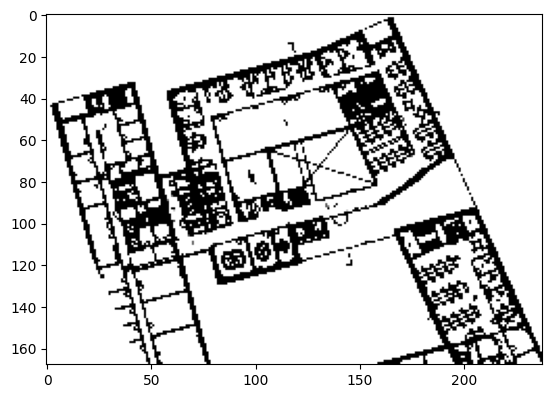

In [ ]:
map_for_crf = np.clip(erosion_dst+img_thresh, 0.0, 1.0)
plt.imshow(map_for_crf, cmap='gray')

In [ ]:
np.save('map.npy', map_for_crf * 255)

In [ ]:
np.save('map_original.npy', img * 255)

In [ ]:
map_for_crf.shape

(168, 238)

In [ ]:
WIDTH = map_for_crf.shape[1]
HEIGHT = map_for_crf.shape[0]
dim = (WIDTH, HEIGHT)
NEIGHBOR_SHIFT = 2
NEIGHBOR_LENGTH = NEIGHBOR_SHIFT*2+1
NEIGHBOR = NEIGHBOR_LENGTH*NEIGHBOR_LENGTH

In [ ]:
bordered = np.zeros([HEIGHT+2*NEIGHBOR_SHIFT, WIDTH+2*NEIGHBOR_SHIFT])
bordered[NEIGHBOR_SHIFT:HEIGHT+NEIGHBOR_SHIFT, NEIGHBOR_SHIFT:WIDTH+NEIGHBOR_SHIFT] = map_for_crf

(-0.5, 241.5, 171.5, -0.5)

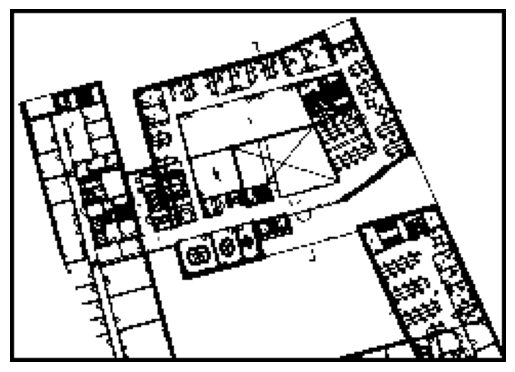

In [ ]:
plt.imshow(bordered, cmap='gray')
plt.axis('off')

In [ ]:
shifted = np.zeros([HEIGHT+2*NEIGHBOR_SHIFT, WIDTH+2*NEIGHBOR_SHIFT, NEIGHBOR])
for idx in range(NEIGHBOR):
    y, x = np.unravel_index(idx, (NEIGHBOR_LENGTH, NEIGHBOR_LENGTH))
    shifted[y:HEIGHT + y, x:WIDTH + x, idx] = map_for_crf
shifted_flip = np.flip(shifted, axis=2)
cut = shifted_flip[NEIGHBOR_SHIFT:HEIGHT+NEIGHBOR_SHIFT, NEIGHBOR_SHIFT:WIDTH+NEIGHBOR_SHIFT, :]

In [ ]:
occupancy = ~ cut.astype(bool)

In [ ]:
transfer_matrix = np.zeros(occupancy.shape).astype(bool)

In [ ]:
transfer_matrix[:,:,0] = occupancy[:,:,0]|occupancy[:,:,6]|(occupancy[:,:,1]&occupancy[:,:,5])|(occupancy[:,:,7]&occupancy[:,:,11])
transfer_matrix[:,:,4] = occupancy[:,:,4]|occupancy[:,:,8]|(occupancy[:,:,3]&occupancy[:,:,9])|(occupancy[:,:,7]&occupancy[:,:,13])
transfer_matrix[:,:,20] = occupancy[:,:,20]|occupancy[:,:,16]|(occupancy[:,:,15]&occupancy[:,:,21])|(occupancy[:,:,11]&occupancy[:,:,17])
transfer_matrix[:,:,24] = occupancy[:,:,24]|occupancy[:,:,18]|(occupancy[:,:,19]&occupancy[:,:,23])|(occupancy[:,:,13]&occupancy[:,:,17])
transfer_matrix[:,:,1] = occupancy[:,:,1]|(occupancy[:,:,6]&occupancy[:,:,7])|(occupancy[:,:,6]&occupancy[:,:,2])|(occupancy[:,:,7]&occupancy[:,:,11])
transfer_matrix[:,:,3] = occupancy[:,:,3]|(occupancy[:,:,7]&occupancy[:,:,8])|(occupancy[:,:,2]&occupancy[:,:,8])|(occupancy[:,:,7]&occupancy[:,:,13])
transfer_matrix[:,:,5] = occupancy[:,:,5]|(occupancy[:,:,6]&occupancy[:,:,11])|(occupancy[:,:,6]&occupancy[:,:,10])|(occupancy[:,:,7]&occupancy[:,:,11])
transfer_matrix[:,:,9] = occupancy[:,:,9]|(occupancy[:,:,8]&occupancy[:,:,13])|(occupancy[:,:,8]&occupancy[:,:,14])|(occupancy[:,:,7]&occupancy[:,:,13])
transfer_matrix[:,:,15] = occupancy[:,:,15]|(occupancy[:,:,11]&occupancy[:,:,16])|(occupancy[:,:,10]&occupancy[:,:,16])|(occupancy[:,:,11]&occupancy[:,:,17])
transfer_matrix[:,:,19] = occupancy[:,:,19]|(occupancy[:,:,13]&occupancy[:,:,18])|(occupancy[:,:,14]&occupancy[:,:,18])|(occupancy[:,:,13]&occupancy[:,:,17])
transfer_matrix[:,:,21] = occupancy[:,:,21]|(occupancy[:,:,16]&occupancy[:,:,17])|(occupancy[:,:,16]&occupancy[:,:,22])|(occupancy[:,:,11]&occupancy[:,:,17])
transfer_matrix[:,:,23] = occupancy[:,:,23]|(occupancy[:,:,17]&occupancy[:,:,18])|(occupancy[:,:,18]&occupancy[:,:,22])|(occupancy[:,:,13]&occupancy[:,:,17])
transfer_matrix[:,:,6] = occupancy[:,:,6]
transfer_matrix[:,:,7] = occupancy[:,:,7]
transfer_matrix[:,:,8] = occupancy[:,:,8]
transfer_matrix[:,:,11] = occupancy[:,:,11]
transfer_matrix[:,:,12] = occupancy[:,:,12]
transfer_matrix[:,:,13] = occupancy[:,:,13]
transfer_matrix[:,:,16] = occupancy[:,:,16]
transfer_matrix[:,:,17] = occupancy[:,:,17]
transfer_matrix[:,:,18] = occupancy[:,:,18]
transfer_matrix[:,:,2] = occupancy[:,:,2]|occupancy[:,:,7]
transfer_matrix[:,:,10] = occupancy[:,:,10]|occupancy[:,:,11]
transfer_matrix[:,:,14] = occupancy[:,:,14]|occupancy[:,:,13]
transfer_matrix[:,:,22] = occupancy[:,:,22]|occupancy[:,:,17]

(-0.5, 237.5, 167.5, -0.5)

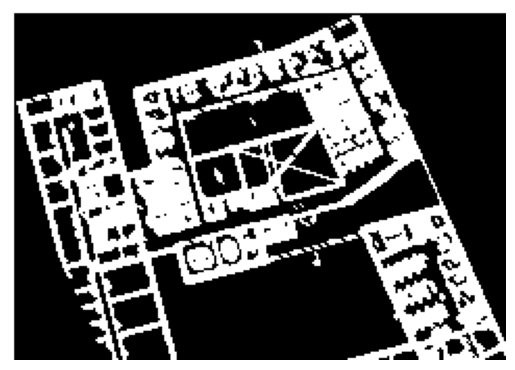

In [ ]:
plt.imshow(transfer_matrix[:, :, 0], cmap='gray')
plt.axis('off')

In [ ]:
transfer_matrix.shape

(168, 238, 25)

In [ ]:
np.save('map_transition.npy', transfer_matrix.astype(bool))

In [ ]:
img_out = plt.imread("BF1_outofbuilding.png")

(-0.5, 237.5, 167.5, -0.5)

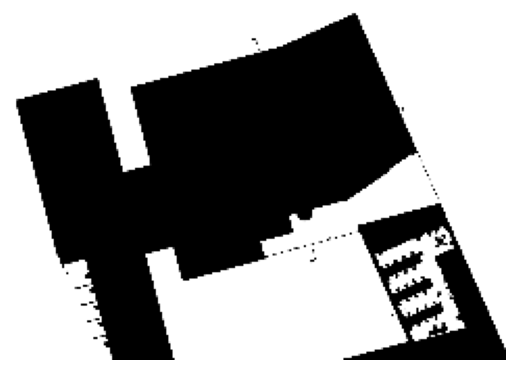

In [ ]:
imgout_rescaled = 1.0 - rescale(img_out[:, :, 0], 0.1, anti_aliasing=False)
plt.imshow(imgout_rescaled, cmap='gray')
plt.axis('off')

In [ ]:
shifted = np.ones([HEIGHT+2*NEIGHBOR_SHIFT, WIDTH+2*NEIGHBOR_SHIFT, NEIGHBOR])
for idx in range(NEIGHBOR):
    y, x = np.unravel_index(idx, (NEIGHBOR_LENGTH, NEIGHBOR_LENGTH))
    shifted[y:HEIGHT + y, x:WIDTH + x, idx] = imgout_rescaled
shifted_flip = np.flip(shifted, axis=2)
cut = shifted_flip[NEIGHBOR_SHIFT:HEIGHT+NEIGHBOR_SHIFT, NEIGHBOR_SHIFT:WIDTH+NEIGHBOR_SHIFT, :]

In [ ]:
np.save('map_unary.npy', cut.astype(bool))

In [ ]:
img_rescaled.shape

(168, 238)

In [ ]:
seq = 23
inertial = np.loadtxt('seq_'+str(seq)+'.txt')

traj_imu = [[0, 0]]
for i in inertial:
    traj_imu.append([traj_imu[-1][0]+i[3]/2, traj_imu[-1][1]+i[4]/2])
    traj_imu.append([traj_imu[-1][0]+i[3]/2, traj_imu[-1][1]+i[4]/2])
traj_imu = np.array(traj_imu)

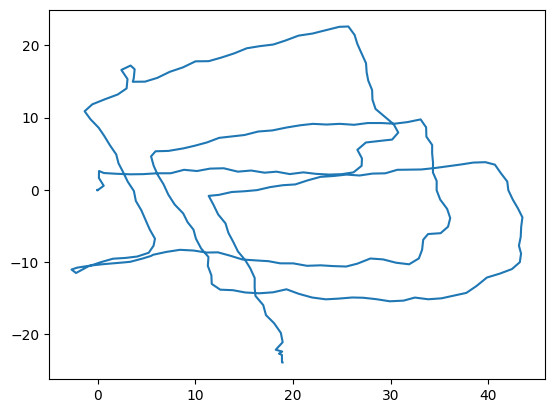

In [ ]:
plt.plot(traj_imu[:, 0], traj_imu[:, 1])

In [ ]:
np.save('trajectory.npy', traj_imu)

In [ ]:
traj_imu.shape

(575, 2)

# Discretize Trajectory

Resolution is 7.2 pixel per inch.

In [ ]:
meter2pix = 39.3701 * 72 / 100 / 10

In [ ]:
seq = 23
inertial = np.loadtxt('seq_'+str(seq)+'.txt')

traj_imu = [[0, 0]]
for i in inertial:
    traj_imu.append([traj_imu[-1][0]+i[3], traj_imu[-1][1]+i[4]])
traj_imu = np.array(traj_imu)

In [ ]:
traj_imu_int = (traj_imu * meter2pix).astype('int')

In [ ]:
# traj_imu_int

In [ ]:
traj_imu_int[1:].shape

(287, 2)

In [ ]:
traj_imu_int[:-1].shape

(287, 2)

In [ ]:
traj_diff = traj_imu_int[1:] - traj_imu_int[:-1]
traj_diff_1 = traj_diff // 2
traj_diff_2 = traj_diff - traj_diff_1
traj_diff_new = np.concatenate((traj_diff_1[:, np.newaxis, :], traj_diff_2[:, np.newaxis, :]), axis=1)
traj_diff_new = traj_diff_new.reshape(-1, 2)
traj_diff_new = np.clip(traj_diff_new, -2, 2)

In [ ]:
# np.set_printoptions(threshold=np.inf)
traj_diff_new.shape

(574, 2)

In [ ]:
traj_from_diff = [np.array([0, 0])]
for i in traj_diff_new:
    traj_from_diff.append(i + traj_from_diff[-1])
traj_from_diff = np.array(traj_from_diff)

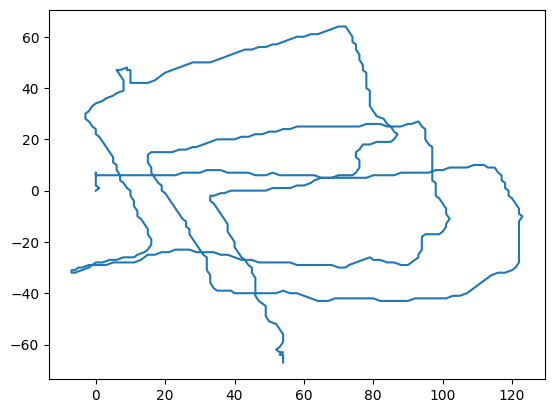

In [ ]:
plt.plot(traj_from_diff[:, 0], traj_from_diff[:, 1])

In [ ]:
traj_from_diff[119,]


array([-63,  68])

In [ ]:
traj_from_diff[:, 1] = -traj_from_diff[:,1]
traj_from_diff = np.flip(traj_from_diff, axis=1)

In [ ]:
np.save('trajectory_discrete.npy', traj_from_diff)

In [ ]:
traj_from_diff.shape

(575, 2)

# Discretize WiFi Localization

In [53]:
seq = 23
inertial = np.loadtxt('seq_'+str(seq)+'.txt')
inertial_ts = inertial[:, 0]
wifi = pd.read_pickle("seq_"+str(seq)+".pickle")
wifi_ts = [float(i)/10 for i in wifi.keys()]
wifi_keys = list(wifi.keys())
wifi_localization = np.array([wifi[i][:, :2] for i in wifi_keys])

In [46]:
wifi_localization_discrete = (wifi_localization * meter2pix).astype('int')

In [47]:
inertial_ts_discrete = np.repeat(inertial_ts, 2)

In [48]:
location_idx = []
for ts in wifi_ts:
    location_idx.append(find_nearest(inertial_ts, ts))

In [49]:
wifi_localization_synced = np.zeros([inertial_ts_discrete.shape[0], 5, 2]).astype('int')
wifi_localization_mask = np.zeros([inertial_ts_discrete.shape[0]]).astype('bool')

In [50]:
for wifi_i, imu_i in enumerate(location_idx):
    wifi_localization_mask[imu_i*2] = True
    wifi_localization_synced[imu_i*2] = wifi_localization_discrete[wifi_i]

In [51]:
wifi_localization_mask.shape

(574,)

In [52]:
wifi_localization_synced.shape

(574, 5, 2)

In [53]:
wifi_localization_synced[:, :, 1] = -wifi_localization_synced[:, :, 1]
wifi_localization_synced = np.flip(wifi_localization_synced, axis=2)

In [54]:
np.save('localization.npy', wifi_localization_synced)

In [55]:
np.save('localization_bool.npy', wifi_localization_mask)

In [56]:
blank = np.zeros((168, 238))

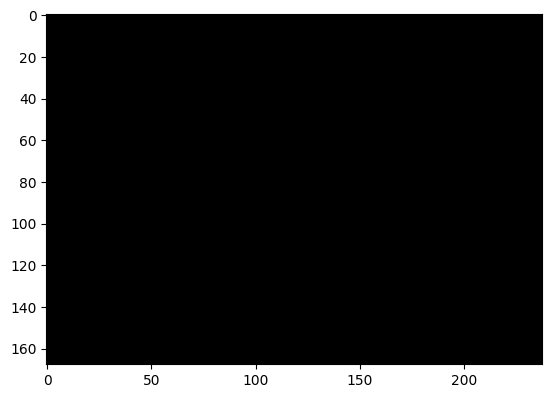

In [57]:
plt.imshow(blank, cmap='gray')

In [58]:
def gaussian_kernel(size, sigma):
    # Create an (size x size) grid of coordinates
    x, y = np.mgrid[-(size // 2):(size // 2) + 1, -(size // 2):(size // 2) + 1]

    # Calculate the 2D Gaussian function at each coordinate
    kernel = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))

    # Normalize the kernel so that the sum of its elements is 1
    kernel /= kernel.sum()

    return kernel

# Example usage:
size = 5
sigma = 2
kernel = gaussian_kernel(size, sigma)
print(kernel)

[[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]]


In [59]:
x = 200
y = 100
blank[y-3:y+2, x-3:x+2] = kernel

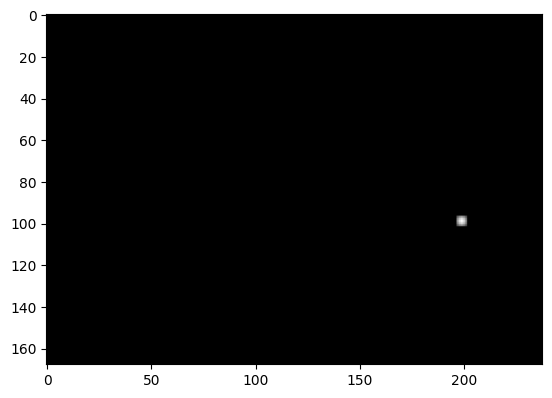

In [60]:
plt.imshow(blank, cmap='gray')

In [61]:
# for (x, y) in traj_imu_int:
#     print(x)

In [62]:
online_traj = np.load('online.npy')
online_traj[:, 0] = -online_traj[:, 0]
online_traj = np.flip(online_traj, axis=1)
online_traj = online_traj / meter2pix

In [63]:
online_sync = online_traj[2::2]

In [64]:
online_sync.shape

(286, 2)

In [65]:
online_traj.shape

(574, 2)

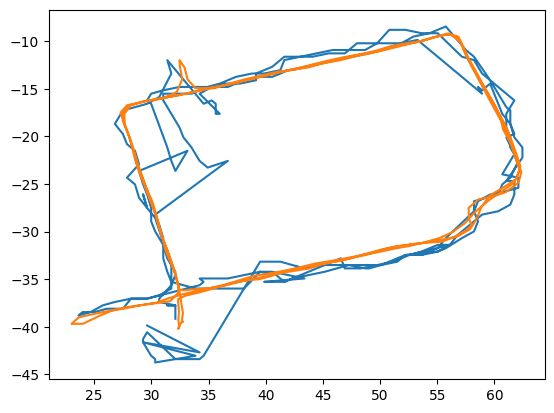

In [66]:
gt = np.load("23_gt.npy")
plt.plot(online_sync[:, 0], online_sync[:, 1])
plt.plot(gt[:, 0], gt[:, 1])

In [67]:
# gt = np.load("23_gt.npy")

In [68]:
np.average(np.linalg.norm(online_sync - gt, axis=1))

2.8498921298997524

In [69]:
def draw_cdf(data,ax,K):
    data = np.array(data).astype(float)
    count, bins_count = np.histogram(data, bins=25)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    ax.plot(bins_count[1:], cdf, label=f"{K}")
    ax.legend()
    return ax

In [70]:
pf_online = np.load('./23_online.npy')  # [286, 3]
pf_gt = np.load('./23_gt.npy')  # [286, 2]

<AxesSubplot:>

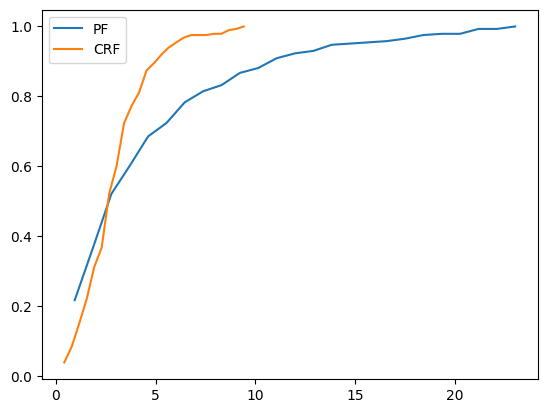

In [71]:
ax = plt.subplot()
plt.rcParams["figure.figsize"] = (4,4)
draw_cdf(np.linalg.norm(pf_online[:, :2] - pf_gt, axis=1), ax,"PF")
draw_cdf(np.linalg.norm(online_sync - gt, axis=1), ax,"CRF")
# draw_cdf(distancec,ax,"imu uncer")

In [72]:
np.linalg.norm(online_sync - gt, axis=1)

array([2.77821805, 2.7812411 , 3.204783  , 3.20398523, 3.51746283,
       3.52128003, 3.33171414, 3.33131086, 4.26001136, 4.26225817,
       4.26450597, 4.26675477, 4.32559187, 4.41814388, 4.50921992,
       5.44675016, 6.09888941, 5.4760555 , 5.87685879, 6.24140396,
       8.39164664, 8.67428592, 9.12369698, 9.41834227, 1.81159469,
       1.08969981, 0.21205493, 0.26429902, 0.49427131, 0.66097274,
       1.53372479, 2.3840034 , 2.35248869, 1.36111848, 1.4089518 ,
       1.08461975, 1.31373578, 0.90629004, 0.69753552, 0.84084431,
       0.59176098, 0.18327657, 0.33764212, 0.12618024, 0.55306068,
       0.67339532, 2.05275921, 1.18895978, 0.84296766, 2.15991267,
       2.4936891 , 2.58237142, 3.48277077, 2.40057393, 2.98290349,
       4.24268081, 2.49090186, 2.28203074, 1.76159091, 1.5056923 ,
       1.42996084, 1.66452926, 1.19973322, 1.22244402, 1.13798517,
       1.18748592, 1.71244119, 1.78126151, 1.58939963, 1.63595076,
       1.71778524, 1.65180379, 1.39140255, 3.4466511 , 4.38495

In [73]:
online_traj

array([[ 56.79719155,  -1.41111035],
       [ 29.63331733, -39.86386736],
       [ 29.63331733, -39.86386736],
       ...,
       [ 32.10276044, -39.15831219],
       [ 32.10276044, -39.15831219],
       [ 32.10276044, -39.15831219]])

In [74]:
online_traj[:, 0] = -online_traj[:, 0]
online_traj = np.flip(online_traj, axis=1)